<a href="https://colab.research.google.com/github/raniaref3at/NER/blob/main/final_GP_NER_for_Biomedical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U transformers
!pip install -U accelerate
!pip install -U datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 5.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
import pandas as pd
from datasets import load_dataset
from google.colab import drive


In [ ]:
data = load_dataset('rania-refaat/NCBI_BC5CDR-Combined-deduplicated')

data

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/9994 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5506 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5739 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 9994
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 5506
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 5739
    })
})

In [ ]:
data['train'].features

{'id': Value(dtype='string', id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-Disease', 'I-Disease', 'B-Chemical', 'I-Chemical'], id=None), length=-1, id=None)}

In [ ]:
pd.DataFrame(data['train'][:]).iloc[0]

id                                                          0
tokens      [Selegiline, -, induced, postural, hypotension...
ner_tags    [3, 0, 0, 1, 2, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, ...
Name: 0, dtype: object

In [ ]:
tags = data['train'].features['ner_tags'].feature
index2tag = {idx:tag for idx, tag in enumerate(tags.names)}
tag2index = {tag:idx for idx, tag in enumerate(tags.names)}

In [ ]:
tags.int2str(1)

'B-Disease'

In [ ]:
def create_tag_names(batch):
  tag_name = {'ner_tags_str': [tags.int2str(idx) for idx in batch['ner_tags']]}
  return tag_name

In [ ]:
data = data.map(create_tag_names)

Map:   0%|          | 0/9994 [00:00<?, ? examples/s]

Map:   0%|          | 0/5506 [00:00<?, ? examples/s]

Map:   0%|          | 0/5739 [00:00<?, ? examples/s]

In [ ]:
pd.DataFrame(data['train'][:]).iloc[0]

id                                                              0
tokens          [Selegiline, -, induced, postural, hypotension...
ner_tags        [3, 0, 0, 1, 2, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, ...
ner_tags_str    [B-Chemical, O, O, B-Disease, I-Disease, O, B-...
Name: 0, dtype: object

##Model Building

In [ ]:
from transformers import AutoTokenizer

model_checkpoint = "henrymark/biobert-biomedical-ner"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
tokenizer.is_fast

True

In [ ]:
input = data['train'][0]['tokens']
input = tokenizer(input)
input.tokens()

['[CLS]', 'Se', '##leg', '##ili', '##ne', '[SEP]']

In [ ]:
 data['train'][0]['tokens']

['Selegiline',
 '-',
 'induced',
 'postural',
 'hypotension',
 'in',
 'Parkinson',
 "'",
 's',
 'disease',
 ':',
 'a',
 'longitudinal',
 'study',
 'on',
 'the',
 'effects',
 'of',
 'drug',
 'withdrawal',
 '.']

In [ ]:
input.word_ids()

[None, 0, 0, 0, 0, None]

In [ ]:
def align_labels_with_tokens(labels, word_ids):
  new_labels = []
  current_word = None
  for word_id in word_ids:
    if word_id != current_word:
      current_word = word_id
      label = -100 if word_id is None else labels[word_id]
      new_labels.append(label)

    elif word_id is None:
       new_labels.append(-100)

    else:
      label = labels[word_id]

      if label%2==1:
         label = label+1
      new_labels.append(label)
  return new_labels

In [ ]:
labels = data['train'][0]['ner_tags']
word_ids = input.word_ids()
print(labels, word_ids)

[3, 0, 0, 1, 2, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [None, 0, 0, 0, 0, None]


In [ ]:
align_labels_with_tokens(labels , word_ids)

[-100, 3, 4, 4, 4, -100]

In [ ]:
def tokenize_and_align_labels(examples):
  tokenized_inputs = tokenizer(examples['tokens'], truncation=True, is_split_into_words=True)

  all_labels = examples['ner_tags']

  new_labels = []
  for i, labels in enumerate(all_labels):
    word_ids = tokenized_inputs.word_ids(i)
    new_labels.append(align_labels_with_tokens(labels, word_ids))

  tokenized_inputs['labels'] = new_labels

  return tokenized_inputs

In [ ]:
tokenized_datasets = data.map(tokenize_and_align_labels, batched=True, remove_columns=data['train'].column_names)


Map:   0%|          | 0/9994 [00:00<?, ? examples/s]

Map:   0%|          | 0/5506 [00:00<?, ? examples/s]

Map:   0%|          | 0/5739 [00:00<?, ? examples/s]

In [ ]:
tokenized_datasets


DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 9994
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 5506
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 5739
    })
})

##Data Collation and Metrics


In [ ]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [ ]:
batch = data_collator([tokenized_datasets['train'][i] for i in range(2)])
batch

{'input_ids': tensor([[  101, 22087, 27412, 18575,  1673,   118, 10645,  2112, 12602,   177,
          1183, 11439,  5026,  1988,  1107, 22195,   112,   188,  3653,   131,
           170, 23191,  2025,  1113,  1103,  3154,  1104,  3850, 10602,   119,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [  101,   152,  2064,  4538,  8231, 21669, 17145,  1708,   131,  1109,
          1244,  2325, 22195,   112,   188, 20012,  2713,  1990,   113,  1993,
         15481,  2069,  2349,   114,  3443,  1276,  1126,  2569, 14471,  1107,
          4420,  1114, 22195,   112,   188,  3653,   113, 27802,   114,  7091,
          2200,  1106,  3531,  1275, 17713, 14516, 27412, 18575,  1673,  1679,
          1285,  1105,   149,   118,  1202,  4163,  3402, 

##Metrics

In [ ]:
!pip install seqeval
!pip install evaluate

import evaluate
metric = evaluate.load('seqeval')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=2bf3387b8f11235f0e35e0be5e430969b8232143a641807661220ab3b221c1a6
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.2 MB/s eta 0:00:00


In [ ]:
ner_feature = data['train'].features['ner_tags']
ner_feature

Sequence(feature=ClassLabel(names=['O', 'B-Disease', 'I-Disease', 'B-Chemical', 'I-Chemical'], id=None), length=-1, id=None)

In [ ]:
label_names = ner_feature.feature.names
label_names

['O', 'B-Disease', 'I-Disease', 'B-Chemical', 'I-Chemical']

In [ ]:
labels = data['train'][0]['ner_tags']
labels = [label_names[i] for i in labels]
labels

['B-Chemical',
 'O',
 'O',
 'B-Disease',
 'I-Disease',
 'O',
 'B-Disease',
 'I-Disease',
 'I-Disease',
 'I-Disease',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O']

In [ ]:
predictions = labels.copy()
predictions[2] = "O"

metric.compute(predictions=[predictions], references=[labels])

{'Chemical': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'Disease': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 2},
 'overall_precision': 1.0,
 'overall_recall': 1.0,
 'overall_f1': 1.0,
 'overall_accuracy': 1.0}

In [ ]:
import numpy as np

def compute_metrics(eval_preds):
  logits, labels = eval_preds

  predictions = np.argmax(logits, axis=-1)

  true_labels = [[label_names[l] for l in label if l!=-100] for label in labels]

  true_predictions = [[label_names[p] for p,l in zip(prediction, label) if l!=-100]
                      for prediction, label in zip(predictions, labels)]

  all_metrics = metric.compute(predictions=true_predictions, references=true_labels)

  return {"precision": all_metrics['overall_precision'],
          "recall": all_metrics['overall_recall'],
          "f1": all_metrics['overall_f1'],
          "accuracy": all_metrics['overall_accuracy']}

##Model Training


In [ ]:
id2label = {i:label for i, label in enumerate(label_names)}
label2id = {label:i for i, label in enumerate(label_names)}

In [ ]:
print(id2label)

{0: 'O', 1: 'B-Disease', 2: 'I-Disease', 3: 'B-Chemical', 4: 'I-Chemical'}


In [ ]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained(
                                                    model_checkpoint,
                                                    id2label=id2label,
                                                    label2id=label2id,
                                                    ignore_mismatched_sizes=True)

pytorch_model.bin:   0%|          | 0.00/431M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at henrymark/biobert-biomedical-ner and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.config.num_labels

5

In [ ]:
!pip install transformers[torch]
!pip install accelerate -U
from transformers import TrainingArguments

args = TrainingArguments("biobert-fine-tuned-ner",
                         evaluation_strategy = "epoch",
                         save_strategy="epoch",
                         learning_rate = 1e-5,
                         num_train_epochs=30,
                         weight_decay=0.01,
                         logging_dir='./logs',
                         logging_steps=10,
                         eval_steps=10,
                         save_steps=10,
                         )

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from transformers import AdamW
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)
epochs = 30
max_grad_norm = 1.0


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.049300,0.040402,0.976886,0.971323,0.974081
2,0.002900,0.041683,0.977196,0.976575,0.976863
3,0.006000,0.067272,0.981654,0.958140,0.969417
4,0.002200,0.061916,0.978873,0.975596,0.977225
5,0.000200,0.071285,0.979852,0.971013,0.975367
6,0.004900,0.078200,0.978943,0.967154,0.972932
7,0.000900,0.078977,0.976912,0.974654,0.975779
8,0.000000,0.081530,0.975739,0.976246,0.975986
9,0.000000,0.094102,0.979756,0.968761,0.974169
10,0.001700,0.086251,0.979638,0.973964,0.976775


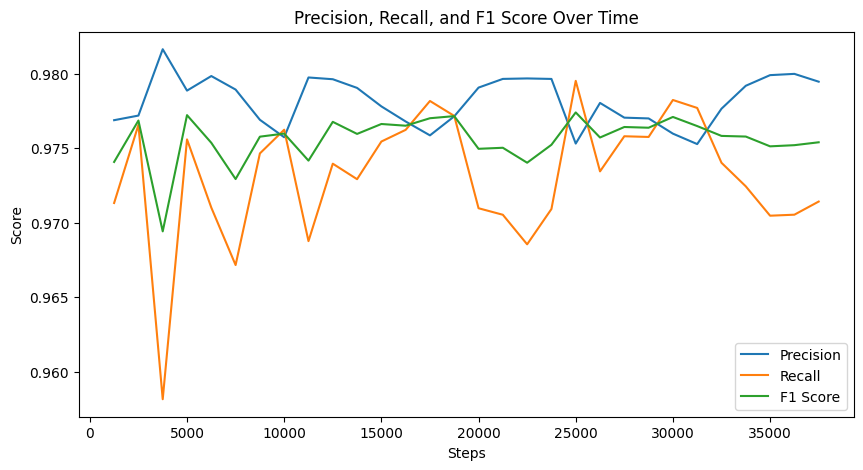

In [ ]:
from transformers import TrainingArguments, Trainer, TrainerCallback
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Define the compute_metrics function
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [pred for pred, lab in zip(prediction, label) if lab != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [lab for pred, lab in zip(prediction, label) if lab != -100]
        for prediction, label in zip(predictions, labels)
    ]

    # Flatten the lists
    true_predictions_flat = [item for sublist in true_predictions for item in sublist]
    true_labels_flat = [item for sublist in true_labels for item in sublist]

    # Compute precision, recall, and f1 score
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels_flat, true_predictions_flat, average='macro')
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

# Step 2: Define the MetricsLoggerCallback class
class MetricsLoggerCallback(TrainerCallback):
    def __init__(self):
        self.train_loss = []
        self.eval_loss = []
        self.precision = []
        self.recall = []
        self.f1 = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if "loss" in logs:
            self.train_loss.append((state.global_step, logs["loss"]))
        if "eval_loss" in logs:
            self.eval_loss.append((state.global_step, logs["eval_loss"]))
        if "eval_precision" in logs:
            self.precision.append((state.global_step, logs["eval_precision"]))
        if "eval_recall" in logs:
            self.recall.append((state.global_step, logs["eval_recall"]))
        if "eval_f1" in logs:
            self.f1.append((state.global_step, logs["eval_f1"]))

metrics_logger = MetricsLoggerCallback()

# Step 3: Modify TrainingArguments
args = TrainingArguments(
    "biobert-fine-tuned-ner",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    num_train_epochs=30,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_steps=10,
    save_steps=10,
)

# Step 4: Add the Callback to the Trainer
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks=[metrics_logger]
)

trainer.train()

# Step 5: Plot the Metrics
# Extract steps and metrics values
eval_steps, precision = zip(*metrics_logger.precision)
_, recall = zip(*metrics_logger.recall)
_, f1 = zip(*metrics_logger.f1)

# Plot precision, recall, and F1 score
plt.figure(figsize=(10, 5))
plt.plot(eval_steps, precision, label='Precision')
plt.plot(eval_steps, recall, label='Recall')
plt.plot(eval_steps, f1, label='F1 Score')
plt.xlabel('Steps')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score Over Time')
plt.legend()
plt.show()


In [ ]:
from transformers import pipeline

checkpoint = "/content/biobert-fine-tuned-ner/checkpoint-8750"
token_classifier = pipeline(
    "token-classification", model=checkpoint, aggregation_strategy="simple"
)

token_classifier("The surgery was performed at John Hopkins Hospital by Dr. Smith. The patient has hypertension ")

[{'entity_group': 'Disease',
  'score': 0.99997306,
  'word': 'hypertension',
  'start': 81,
  'end': 93}]

In [ ]:
!zip -r biobert-ner.zip "/content/biobert-fine-tuned-ner/checkpoint-8750"

  adding: content/biobert-fine-tuned-ner/checkpoint-8750/ (stored 0%)
  adding: content/biobert-fine-tuned-ner/checkpoint-8750/config.json (deflated 52%)
  adding: content/biobert-fine-tuned-ner/checkpoint-8750/model.safetensors (deflated 7%)
  adding: content/biobert-fine-tuned-ner/checkpoint-8750/tokenizer.json (deflated 70%)
  adding: content/biobert-fine-tuned-ner/checkpoint-8750/trainer_state.json (deflated 85%)
  adding: content/biobert-fine-tuned-ner/checkpoint-8750/optimizer.pt (deflated 21%)
  adding: content/biobert-fine-tuned-ner/checkpoint-8750/training_args.bin (deflated 51%)
  adding: content/biobert-fine-tuned-ner/checkpoint-8750/special_tokens_map.json (deflated 42%)
  adding: content/biobert-fine-tuned-ner/checkpoint-8750/vocab.txt (deflated 49%)
  adding: content/biobert-fine-tuned-ner/checkpoint-8750/tokenizer_config.json (deflated 76%)
  adding: content/biobert-fine-tuned-ner/checkpoint-8750/scheduler.pt (deflated 56%)
  adding: content/biobert-fine-tuned-ner/checkp